In [27]:
import torch
import numpy as np
from datasets import *
from models import MUnet,Unet
import torch.nn.functional as F
from utils import onehot2mask
import matplotlib.pyplot as plt
model = Unet(1,4)
# load state dict
model.load_state_dict(torch.load('output/seg/best_dice.pth'))
model.eval()
k=2

In [28]:
import SimpleITK as sitk
index = 45
labelroot = 'datasets/test/C0LET2_gt_for_challenge19/LGE_manual_35_TestData/patient'+str(index) +'_LGE_manual.nii.gz'
imageroot = 'datasets/train/all_image/patient' + str(index) +'_LGE.nii.gz'
image = sitk.ReadImage(imageroot,sitk.sitkFloat32)
image = sitk.GetArrayFromImage(image)
label = sitk.ReadImage(labelroot)
label = sitk.GetArrayFromImage(label)

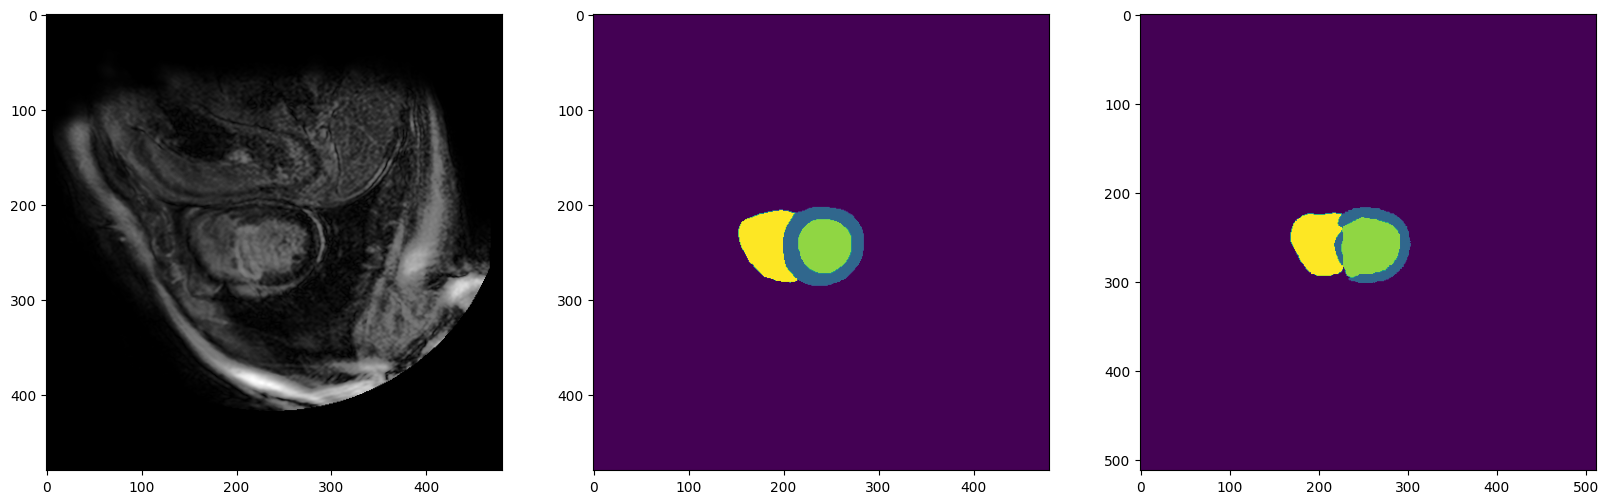

In [30]:
import matplotlib.pyplot as plt
import albumentations as A
from preprocess import slice_histogram_match
from utils import reverse_centercrop
slice = 7
input_ = image[slice]
ii = []
ii.append(input_)
# do histogram_match
input_i = slice_histogram_match(ii)[0]
# do center crop
center = A.CenterCrop(320,320)(image=input_i)
iii = center['image']
input = torch.tensor(iii).unsqueeze(dim=0)
input = minmax_normal(input).unsqueeze(dim=0)
target = label[slice]
predict = model(input)
output = F.softmax(predict.detach(),dim=1).squeeze(dim=0)
remark = [[0.0],[200.0],[500.0],[600.0]]
label_ = onehot2mask(output,remark)
label_ = reverse_centercrop(label_,size=512)
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(input_i,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(target)
plt.subplot(1,3,3)
plt.imshow(label_)

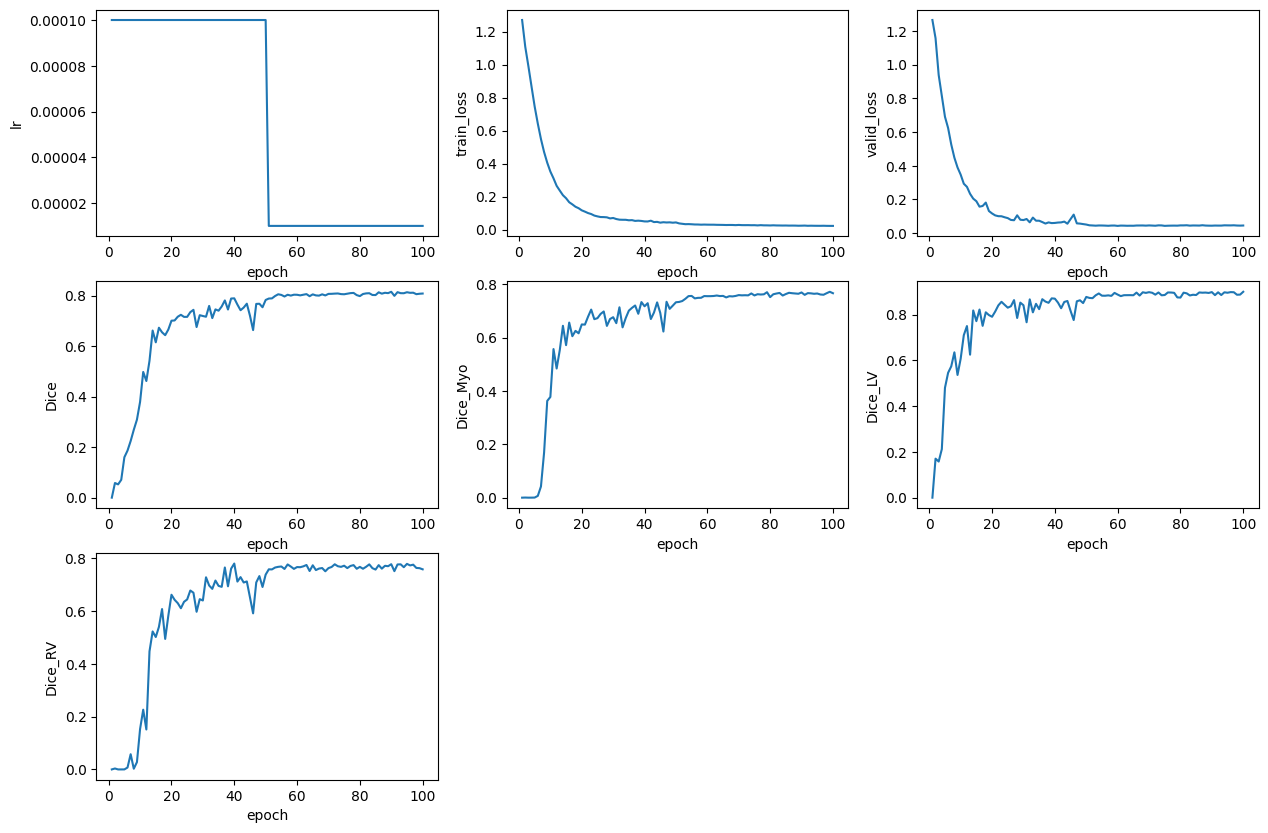

In [31]:
# 查看segmentation任务的情况
import matplotlib.pyplot as plt
import pandas as pd

loss = pd.read_csv('output/seg/loss.csv')
x = loss['epoch'].tolist()
lens = len(loss.columns.tolist()) - 1
x_dim = len(loss.columns.tolist()) // 3 - 1
plt.figure(figsize=(15,10))
for i in range(lens - 4):
    label = loss.columns.tolist()[i+1]
    loss_ = loss[label].tolist()
    axis = plt.subplot(x_dim,3,i+1)
    axis.set_xlabel('epoch')
    axis.set_ylabel(label)
    axis.plot(x,loss_)
plt.show()